### Introduction to Data Science
## Homework 3: Due 5pm to My Mailbox (2nd Floor, 19 W 4th St) Wednesday April 19th

**Student Name: Jubin Soni**

**Student Netid: jas1464**

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def cleanBosonData(infile_name):
    data_clean = pd.read_csv(infile_name, index_col='EventId')
    minority_label = data_clean.Label.value_counts()
    minority_label = minority_label
    [minority_label==minority_label.min()].index[0]
    data_clean['Y'] = data_clean.Label
    .apply(lambda x: 1 if x == minority_label else 0)
    data_clean.drop('Label', axis=1, inplace=True)
    cols = (data_clean == -999).any()[lambda x: x].index
    data_clean[cols + "_mv"] = data_clean[cols]
    .where(data_clean[cols] == -999, 0)
    data_clean[cols + "_mv"] = data_clean[cols + "_mv"]
    .where(data_clean[cols + "_mv"] != -999, 1)
    avg_of_each_feature = np.mean(data_clean[cols]
                        .where(data_clean[cols] != -999, 0))
    data_clean[cols] = data_clean[cols].replace
                        (-999, avg_of_each_feature)
    #rescaled_data_clean = (data_clean.iloc[:,:9] 
    #- data_clean.iloc[:,:9].mean()) / data_clean.iloc[:,:9].std(ddof=0)
    rescaled_data_clean = data_clean.iloc[:,:9]
    .apply(StandardScaler(with_mean=True, with_std=True).fit_transform)
    data_clean = pd.concat ([rescaled_data_clean, 
                        data_clean.iloc[:, 10:], data_clean.Y], axis=1)
    return data_clean

### Part 2: Basic evaluations
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

#### 1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [4]:
import warnings
warnings.filterwarnings("ignore")
data_train = cleanBosonData("https://raw.githubusercontent.com/kmunger/
                            +"DataScienceCourse/master/ipython/hw/hw_3/
                            +"data/boson_training_cut_2000.csv")
data_test = cleanBosonData("https://raw.githubusercontent.com/kmunger/
                           +"DataScienceCourse/master/ipython/hw/hw_3/
                           +"data/boson_testing_cut.csv")

#### 2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

LR:
 fpr:[ 0.          0.10536894  1.        ], tpr:[ 0.          0.38291674  1.        ]
SVM:
 fpr:[ 0.          0.03027073  1.        ], tpr:[ 0.          0.16273379  1.        ]


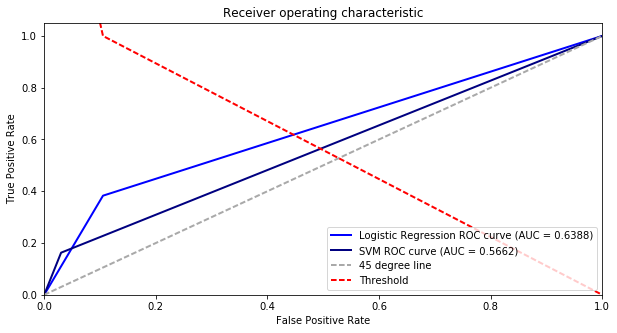

In [5]:
import matplotlib
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

#Splitting the dataset into training and test
X_train, y_train = data_train.iloc[:, 0:9], data_train.Y.values
X_test, y_test = data_test.iloc[:, 0:9], data_test.Y.values


#Training data on Logistic Regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(C=1e30)
log_model.fit(X_train, y_train)
predicted_lr = log_model.predict(X_test)

fpr_lr = {}
tpr_lr = {}
fpr_lr, tpr_lr, _ = roc_curve(y_test, predicted_lr)
print ("LR:\n fpr:{0}, tpr:{1}". format(fpr_lr, tpr_lr))
auc_lr = auc(fpr_lr, tpr_lr)


#Training data on SVM
from sklearn.svm import SVC
svm = SVC(kernel="linear", probability=True)
svm = svm.fit(X_train, y_train)
predicted_svm = svm.predict(X_test)

fpr_svm = {}
tpr_svm = {}
fpr_svm, tpr_svm, _ = roc_curve(y_test, predicted_svm)
print ("SVM:\n fpr:{0}, tpr:{1}". format(fpr_svm, tpr_svm))
auc_svm = auc(fpr_svm, tpr_svm)


#Plotting the results
plt.figure(figsize=(10,5))

plt.plot(fpr_lr, tpr_lr, color='blue',
         lw=2, label='Logistic Regression ROC curve
         +'(AUC = %0.4f)' % auc_lr)

plt.plot(fpr_svm, tpr_svm, color='navy',
         lw=2, label='SVM ROC curve
         +'(AUC = %0.4f)' % auc_svm)

plt.plot([0, 1], [0, 1], color='darkgrey', lw=2,
         linestyle='--', label='45 degree line')
plt.plot(fpr_lr, _, color='red', lw=2, linestyle='--',
         label='Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### 3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?


Answer 3: Logistic Regression is better at ranking the test set. At highest values of threshold SVM performs better.

### Part 3: Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

#### 1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [6]:
def xValSVM(dataset, label_name, k, cs):
    aucs = {}
    AUC_c_k = []
    start = dataset.index[0]
    parts = math.ceil(float(dataset.shape[0])/k)
    
    #Creating different folds
    for f in range(k):
        if f == (k-1):
            end = dataset.index[0] + len(dataset) - 1
        else:
            end = start + parts
        
        #Splitting dataset into training and validation
        data_validate = dataset.loc[start:end]
        data_train = dataset.drop(data_validate.index.tolist())

        #Splitting features and labels training 
        #and validation data for SVM
        X_train, y_train = data_train.iloc[:, 0:9], 
                    data_train[label_name].values
        X_validate, y_validate = data_validate.iloc[:, 0:9], 
                        data_validate[label_name].values

        for c in cs:
            svm_model = SVC(C = c, kernel='linear')
            svm_model = svm_model.fit(X_train, y_train)
            y_predicted_svm = svm_model.predict(X_validate)
            fpr, tpr, _ = roc_curve(y_validate, y_predicted_svm)
            AUC_c_k = auc(fpr, tpr)
            if c in aucs:
                aucs[c].append(AUC_c_k)
            else:
                aucs[c] = [AUC_c_k]
        start = end
    return  aucs

#### 2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

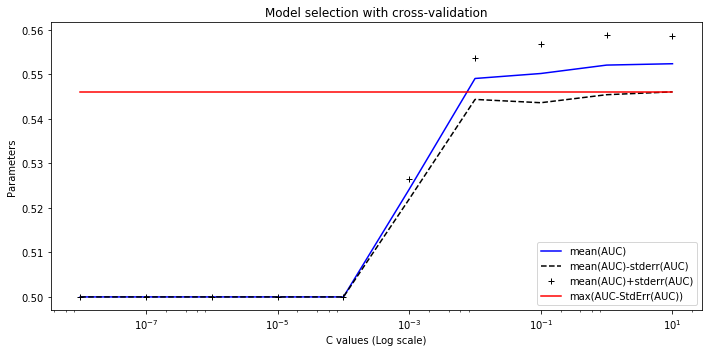

In [7]:
#Calling xValSVM and storing dictionary output in aucs
aucs = xValSVM(data_train, 'Y', k=10, cs = [10**i for i in range(-8,2)])

#Creating aucs dataframe
aucs = pd.DataFrame(aucs)

#calculating mean(AUC) for each c in cs
mean_AUC = np.mean(aucs)

#calculating StdErr(AUC) for each c in cs
StdErr_AUC = aucs.sem() #sem: standard err of mean

#Computing boundry values Mean-StdErr and Mean+StdErr
sem_minus = mean_AUC - StdErr_AUC
sem_plus = mean_AUC + StdErr_AUC

#computing Max(mean_AUC-StdErr_AUC)
max_AUC = np.max(mean_AUC - StdErr_AUC)

#Plotting the results
plt.figure(figsize=(10,5))
plt.plot(mean_AUC, 'b', label='mean(AUC)')
plt.plot(sem_minus, 'k--', label='mean(AUC)-stderr(AUC)')
plt.plot(sem_plus, 'k+', label='mean(AUC)+stderr(AUC)')
plt.plot([aucs.columns[0], aucs.columns[-1]], [max_AUC, max_AUC], 
                 'r', label='max(AUC-StdErr(AUC))')
plt.xlabel('C values (Log scale)')
plt.ylabel('Parameters')
plt.title('Model selection with cross-validation')
plt.legend(loc="lower right")
plt.xscale('log')
plt.tight_layout()
plt.show()


Answer 2: No, the model parameters we selected do not beat Out-of-the box SVM.

#### 3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?



Answer 3: Logistic Regression is better in this case. I think it is not a worthy investment because we are trying to fit SVM with linear kernel on different C values which takes a lot of time to execute and it does not help our AUC score much. Since SVM tries to maximize margin between closest support vectors fit consumes a lot of time to occur for larger C values.

#### 4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?




Answer 4: Yes because we have training set of 2000 records the 10-fold cross validation would use training sets of size 1600 which would behave much like a full set. Hence as an estimate of Err clross validation is biased in upward direction.

Thank you.